In [2]:
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt


class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未
        # 获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0


np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


In [4]:
class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

In [5]:
class EpsilonGreedy(Solver):
    """ epsilon贪婪算法,继承Solver类 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

epsilon-贪婪算法的累积懊悔为： 78.32408479149277


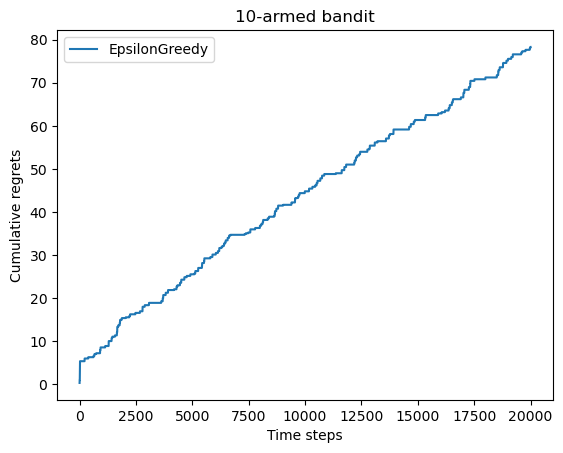

In [8]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()


np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(20000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

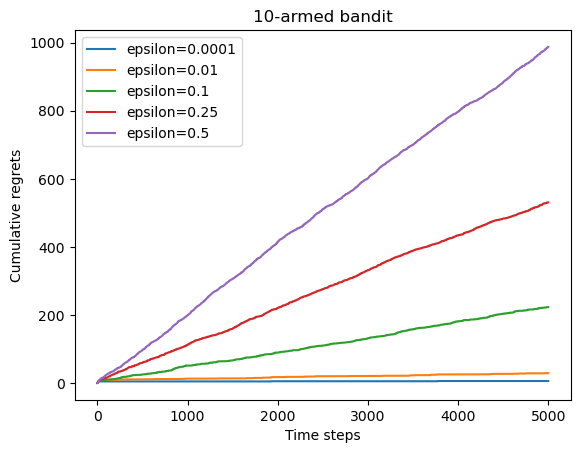

In [9]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183


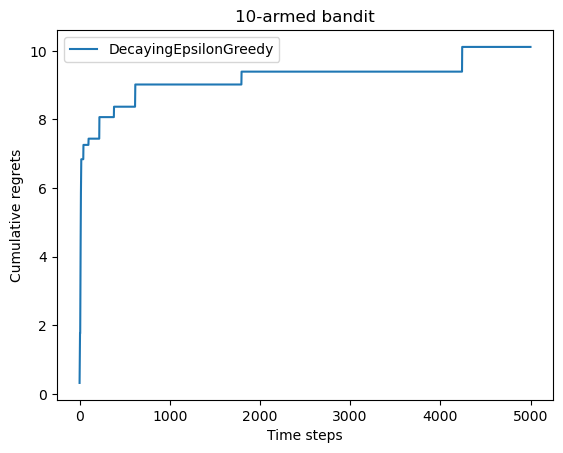

In [10]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

epsilon值衰减的贪婪算法的累积懊悔为： 11.261472136510273


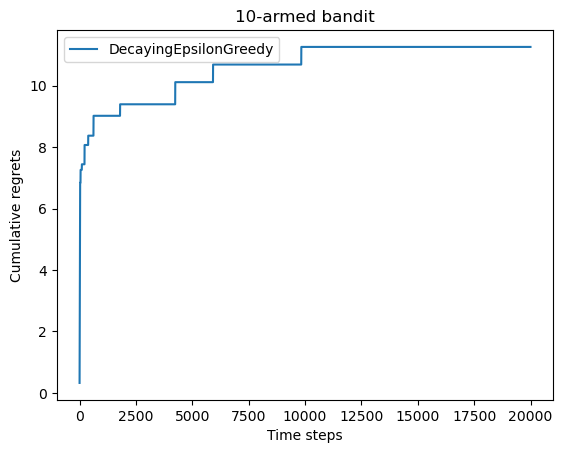

In [12]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(20000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

上置信界算法的累积懊悔为： 70.45281214197854


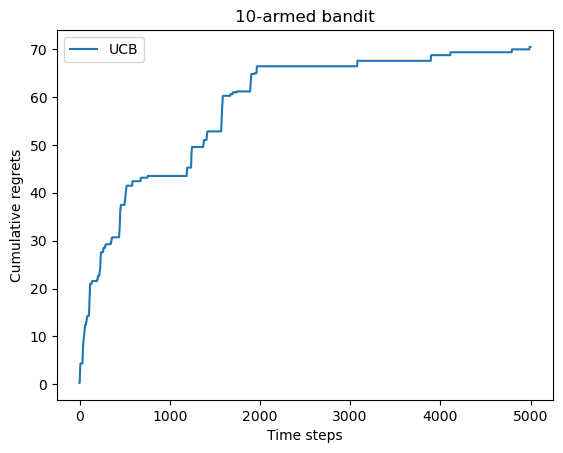

In [13]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k


np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

sample [3.78164892e-04 6.13798727e-01 3.50231061e-01 4.24085262e-01
 3.92453864e-02 4.27568748e-01 4.14746642e-01 6.85293315e-01
 1.89327153e-01 2.37994556e-02]
sample [0.8843413  0.50502143 0.87036454 0.76233941 0.35073268 0.0850426
 0.19935024 0.45674183 0.89237247 0.49674501]
sample [0.70631424 0.6326096  0.00462945 0.38262124 0.01673748 0.55687796
 0.08034465 0.64747016 0.32890878 0.30784966]
sample [0.74570755 0.02276058 0.69487804 0.73144586 0.32260807 0.14853829
 0.44619132 0.38653887 0.79570374 0.84094563]
sample [0.00985666 0.60397275 0.71640651 0.15199803 0.74976053 0.91878783
 0.23224325 0.36553055 0.14443159 0.34601727]
sample [0.09836119 0.48326444 0.95917045 0.0785449  0.71710637 0.81407149
 0.3682075  0.34653357 0.54208098 0.55245951]
sample [1.71985838e-02 4.11421270e-04 2.11178741e-01 3.27341967e-01
 4.81896779e-01 8.48753118e-01 3.17574173e-01 1.68327187e-01
 3.53950911e-01 6.16786951e-01]
sample [0.5312035  0.57608928 0.07159463 0.18280629 0.77963181 0.71725248
 0.36

sample [0.38323439 0.73930781 0.11028589 0.1445417  0.25735218 0.38034227
 0.0276293  0.29830108 0.63402003 0.52611192]
sample [0.26679987 0.70857328 0.08405778 0.13150312 0.08048386 0.23529758
 0.32127168 0.54128823 0.57657007 0.5271151 ]
sample [0.34233759 0.71678652 0.3034244  0.02592297 0.31976904 0.04336022
 0.08115805 0.2910354  0.56548924 0.63091089]
sample [0.37550235 0.70219829 0.21491236 0.00667783 0.5150137  0.32504034
 0.05183975 0.13991206 0.32585321 0.59971307]
sample [0.64854564 0.71897989 0.03268272 0.1552876  0.28996005 0.43639591
 0.01736224 0.19668236 0.55114478 0.78051656]
sample [0.48280166 0.71028978 0.00364939 0.04393832 0.23391143 0.19470354
 0.06192156 0.34789546 0.32279569 0.69817876]
sample [0.57315732 0.73334139 0.08353486 0.00906763 0.18404248 0.04584688
 0.19880152 0.26683056 0.41293462 0.55944066]
sample [0.4666977  0.71161938 0.22620441 0.24739043 0.30261879 0.31714624
 0.00686652 0.19970435 0.27196247 0.41674842]
sample [0.35016625 0.72224902 0.02236229

sample [0.36605357 0.72908894 0.02621709 0.03627409 0.23273726 0.04972812
 0.18455455 0.24294542 0.36618808 0.66017301]
sample [0.39504344 0.73083238 0.0980668  0.22006806 0.25503579 0.15284295
 0.27341926 0.41332946 0.37015114 0.61395415]
sample [0.37837748 0.72228963 0.26430392 0.09397556 0.26613267 0.11429402
 0.16310445 0.34086117 0.19377547 0.52295838]
sample [0.27790428 0.73085142 0.26115668 0.23429059 0.05739774 0.06218743
 0.08014376 0.3944153  0.49584309 0.63331608]
sample [0.38144547 0.72986941 0.05428411 0.22055564 0.22376682 0.14847805
 0.16260039 0.1107639  0.13400123 0.52526784]
sample [0.56385007 0.7150679  0.07067998 0.01779922 0.2174266  0.35571528
 0.16261099 0.36980708 0.34295709 0.66466113]
sample [0.30759942 0.70670825 0.03877463 0.28719839 0.18486562 0.17564921
 0.5328037  0.20797473 0.26555086 0.57602233]
sample [0.68437395 0.73960884 0.06046759 0.0888917  0.34719887 0.26416543
 0.08041336 0.3234066  0.3598532  0.56188893]
sample [0.4399361  0.7172359  0.08831168

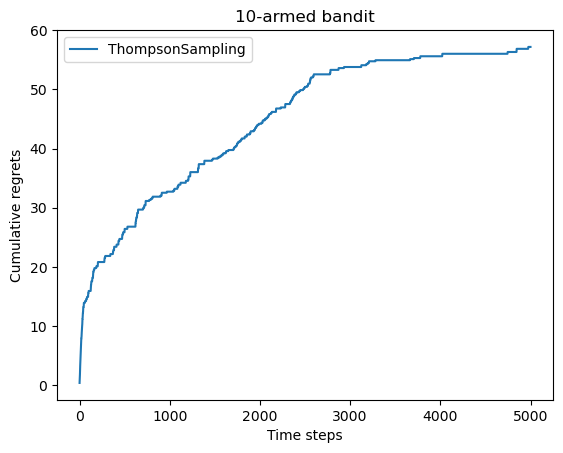

In [18]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)
        print('sample',samples)
        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k


np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])